# Hard drive failure prediction for SAS disks

Особый интерес для исследований представляют SAS диски, так как они используются в современных СХД и серверах. SAS диски представляют smart параметры, отличные от smart параметров SATA дисков (представленных в существующих статьях на тему прогнозирования отказов дисков).

Пример SMART репорта SAS диска может быть найден [тут](https://hardforum.com/threads/seagate-sas-in-sm-jbod-lots-of-read-errors-anyone-else.1878472/) и [тут](http://sg.danny.cz/scsi/smartmontools_scsi.html).

Документация к SMART параметрам SAS дисков:
- [smartmontools scsi](https://www.smartmontools.org/browser/trunk/www/smartmontools_scsi.xml)
- [scsi sas nvme does not provide SATA like attributes](https://www.smartmontools.org/wiki/FAQ#MySCSISASdriveisnotinthesmartctlsmartddatabase)



Примерное отображение SATA параметров в SAS:

| SMART parameter for SATA | SATA SMART id | SMART parameter for SAS|
| --- | --- | --- |
| Power-on Time hours | 09  | Number of hours powered up| 
|(HDA) temperature | 194 | Current Drive Temperature | 
| Reallocated sectors count | 05 | Grown defects list |
|Read error rate | 01 | Total uncorrected errors read (?) | 
|Write error rate | 200 | Uncorrected errors write + corrected errors write (?) |
|Reported uncorrectable errors | 187 | Total uncorrected (sum?)|
| Load / unload cycle count | 193 | Accumulated load / unload cycles |
| Start / stop count | 04 | Accumulated start / stop cycles |
| Hardware ECC recovered | 195 | ECC delayed / fast (?) |
| Soft ECC correction | 204 | ECC delayed / fast (?) | 

Оставим только эти параметры для исследовавшегося ранее BackBlaze датасета SATA дисков. Возможно, выводы, основанные на таком датасете, могут пригодиться для датасета реальных SAS дисков.

## Investigating dataset with potential SAS disks parameters
### Preliminary

In [73]:
import pandas as pd

# Concatenating all datasets (one dataset per month 2017) to one
##df_bb = pd.concat(map(pd.read_csv, glob.glob("./backblaze_ST4000DM000/*.csv")))
df_bb = pd.read_csv('./backblaze_ST4000DM000/model_2018_ST4000DM000.csv')
df_bb.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2018-01-01,Z3016TK2,ST4000DM000,4000787030016,0,115.0,87117728.0,NaN,NaN,96.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01,W300GLSS,ST4000DM000,4000787030016,1,111.0,40108520.0,NaN,NaN,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-01,Z302SXQ0,ST4000DM000,4000787030016,0,119.0,208926768.0,NaN,NaN,94.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-01,Z3025L3F,ST4000DM000,4000787030016,1,111.0,30947064.0,NaN,NaN,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-01,Z302SW9C,ST4000DM000,4000787030016,0,117.0,137764288.0,NaN,NaN,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
df_bb['failure'].value_counts()

0    367482
1     12596
Name: failure, dtype: int64

In [75]:
df_bb_normalized = df_bb[df_bb.columns.drop(list(df_bb.filter(regex='raw')))]
feat_names_normalized = df_bb_normalized.columns.values
print("Dataset with normalized features values", feat_names_normalized)
print(df_bb_normalized.shape)

Dataset with normalized features values ['date' 'serial_number' 'model' 'capacity_bytes' 'failure'
 'smart_1_normalized' 'smart_2_normalized' 'smart_3_normalized'
 'smart_4_normalized' 'smart_5_normalized' 'smart_7_normalized'
 'smart_8_normalized' 'smart_9_normalized' 'smart_10_normalized'
 'smart_11_normalized' 'smart_12_normalized' 'smart_13_normalized'
 'smart_15_normalized' 'smart_22_normalized' 'smart_177_normalized'
 'smart_179_normalized' 'smart_181_normalized' 'smart_182_normalized'
 'smart_183_normalized' 'smart_184_normalized' 'smart_187_normalized'
 'smart_188_normalized' 'smart_189_normalized' 'smart_190_normalized'
 'smart_191_normalized' 'smart_192_normalized' 'smart_193_normalized'
 'smart_194_normalized' 'smart_195_normalized' 'smart_196_normalized'
 'smart_197_normalized' 'smart_198_normalized' 'smart_199_normalized'
 'smart_200_normalized' 'smart_201_normalized' 'smart_220_normalized'
 'smart_222_normalized' 'smart_223_normalized' 'smart_224_normalized'
 'smart_225_n

In [76]:
columns_with_values = df_bb_normalized.columns[df_bb_normalized.isnull().sum() <= 100]
df_bb_normalized = df_bb_normalized[columns_with_values]
df_bb_normalized.isnull().sum()

date                     0
serial_number            0
model                    0
capacity_bytes           0
failure                  0
smart_1_normalized      16
smart_3_normalized      16
smart_4_normalized      16
smart_5_normalized      16
smart_7_normalized      16
smart_9_normalized      16
smart_10_normalized     16
smart_12_normalized     16
smart_183_normalized    16
smart_184_normalized    16
smart_187_normalized    16
smart_188_normalized    16
smart_189_normalized    16
smart_190_normalized    16
smart_191_normalized    16
smart_192_normalized    16
smart_193_normalized    16
smart_194_normalized    16
smart_197_normalized    16
smart_198_normalized    16
smart_199_normalized    16
smart_240_normalized    16
smart_241_normalized    16
smart_242_normalized    16
dtype: int64

Нужны параметры: 1, 4, 5, 9, 187, 193, 194, 200

In [77]:
sas_params = ['failure', 'smart_1_normalized', 'smart_4_normalized', 'smart_5_normalized', 
              'smart_9_normalized', 'smart_187_normalized', 
              'smart_193_normalized', 'smart_194_normalized'] #, 'smart_204_normalized', 'smart_195_normalized']
df_bb_normalized = df_bb_normalized[sas_params]

In [78]:
df_bb_normalized.isnull().sum()

failure                  0
smart_1_normalized      16
smart_4_normalized      16
smart_5_normalized      16
smart_9_normalized      16
smart_187_normalized    16
smart_193_normalized    16
smart_194_normalized    16
dtype: int64

In [79]:
df_bb_normalized.shape

(380078, 8)

In [80]:
df_bb_normalized = df_bb_normalized.dropna()
df_bb_normalized.shape

(380062, 8)

In [81]:
df_bb_normalized.isnull().sum()

failure                 0
smart_1_normalized      0
smart_4_normalized      0
smart_5_normalized      0
smart_9_normalized      0
smart_187_normalized    0
smart_193_normalized    0
smart_194_normalized    0
dtype: int64

### Splitting data

In [131]:
from sklearn.model_selection import train_test_split

X = df_bb_normalized.drop('failure', axis=1)
y = df_bb_normalized['failure']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (285046, 7)
Shape of X_test:  (95016, 7)
Shape of y_train:  (285046,)
Shape of y_test (95016,)


### Applying models

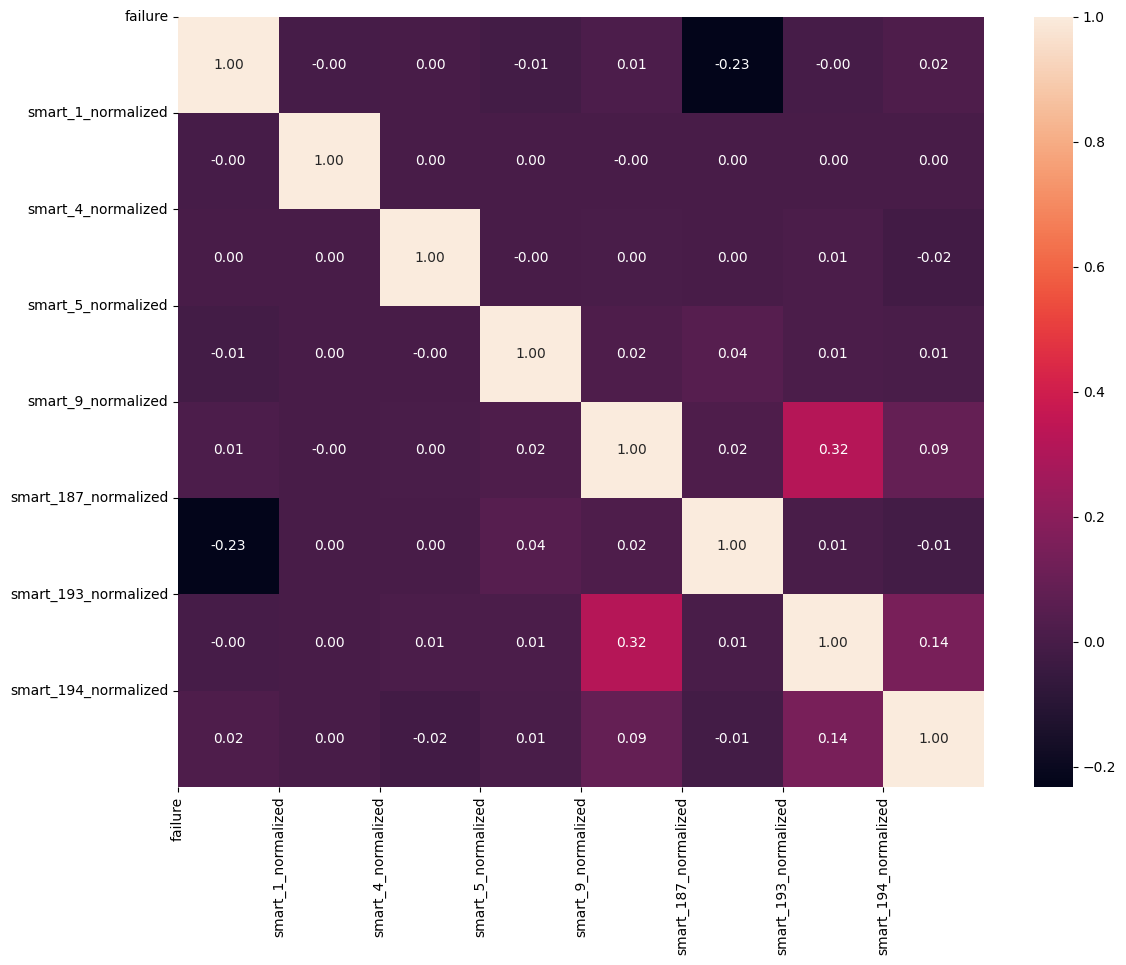

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#df_bb_numeric = df_bb_normalized.drop(columns=string_columns, axis=1)

corr = df_bb_normalized.corr()
#Plot figsize
fig, ax = plt.subplots(figsize=(13, 10))
#Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, annot=True, fmt=".2f")
#Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns);
#Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
#show plot
plt.show()

#### Applying RF

In [43]:
from sklearn.ensemble import RandomForestClassifier
import time 

clf = RandomForestClassifier(n_estimators=10, random_state=42)

t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
print(current_time)
clf.fit(X_train, y_train)
print(time.strftime("%H:%M:%S", time.localtime()))

18:53:00
18:53:03


Training set accuracy:  0.9846901903552409
Test set accuracy:  0.9764671213269344


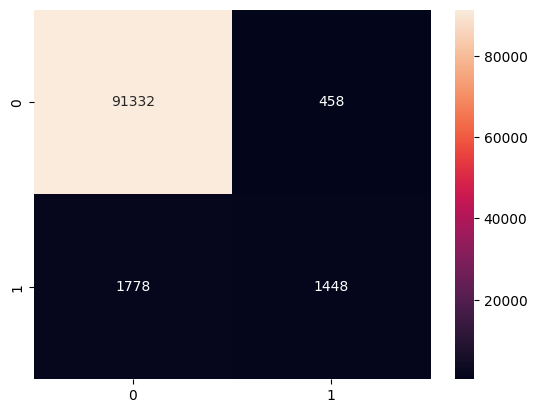

In [44]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

y_pred_train = clf.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
print("Training set accuracy: ", accuracy_train)

y_pred_test = clf.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Test set accuracy: ", accuracy_test)
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='.0f')
plt.show()

#### KNN

In [48]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)

t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
print(current_time)
knn.fit(X_train, y_train)
print(time.strftime("%H:%M:%S", time.localtime()))
print(X_train.shape, X_test.shape)

18:55:17
18:55:18
(285046, 7) (95016, 7)


Training set accuracy:  0.9799155224069097
Test set accuracy:  0.9756988296707922


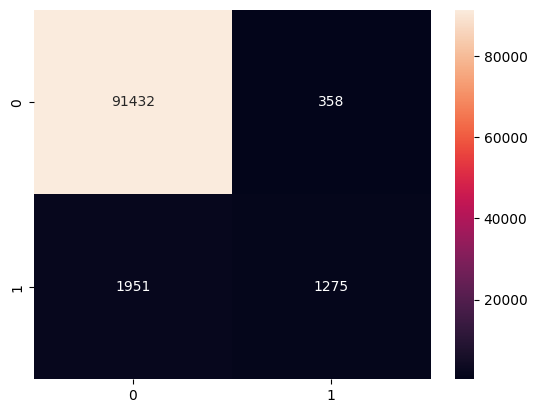

In [49]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

y_pred_train = knn.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
print("Training set accuracy: ", accuracy_train)

y_pred_test = knn.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Test set accuracy: ", accuracy_test)
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='.0f')
plt.show()

#### SVM

In [50]:
import time
from sklearn.svm import SVC

t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
print(current_time)
model = SVC(random_state=42)
model.fit(X_train, y_train)
t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
print(current_time)

18:57:53
19:13:13


Training set accuracy:  0.9674964742532784
Test set accuracy:  0.9665003788835564


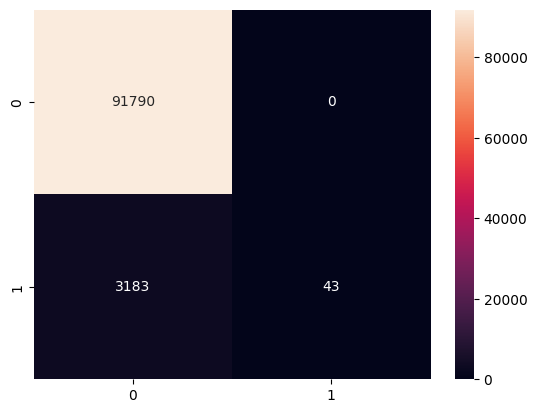

In [51]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

y_pred_train = model.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
print("Training set accuracy: ", accuracy_train)

y_pred_test = model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Test set accuracy: ", accuracy_test)
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='.0f')
plt.show()

#### BPNN 

In [83]:
from keras.models import Sequential
from keras.layers import Dense, Activation
import numpy as np

In [132]:
model = Sequential()
model.add(Dense(10, input_shape=(7,)))
model.add(Activation('sigmoid'))
model.add(Dense(1))
model.add(Activation('sigmoid')) 

model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy']) 
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 10)                80        
                                                                 
 activation_8 (Activation)   (None, 10)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                                 
 activation_9 (Activation)   (None, 1)                 0         
                                                                 
Total params: 91
Trainable params: 91
Non-trainable params: 0
_________________________________________________________________


In [133]:
model.fit(X_train, y_train, epochs=1, batch_size=10)

#_, accuracy = model.evaluate(X_test, y_test)
#print('Accuracy: %.2f' % (accuracy*100))

28505/28505 [==============================] - 144s 5ms/step - loss: 0.0326 - accuracy: 0.9671


In [136]:
y_pred_test = model.predict(X_test)

y_pred_1 = y_pred_test[:,0]
result = confusion_matrix(y_test, y_pred_1)
print(result)

2970/2970 [==============================] - 16s 5ms/step


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [ ]:
result = confusion_matrix(y_test, y_pred_test)
result